In [ ]:
#@title BUILD ENV
!git clone https://github.com/JoePenna/Dreambooth-Stable-Diffusion
%cd Dreambooth-Stable-Diffusion

!git checkout feature/google-colab-notebook

!pip install omegaconf
!pip install einops
!pip install pytorch-lightning==1.6.5
!pip install test-tube
!pip install transformers
!pip install kornia
!pip install -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers
!pip install -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install setuptools==59.5.0
!pip install pillow==9.0.1
!pip install torchmetrics==0.6.0
!pip install -e .
!pip install protobuf==3.20.1
!pip install gdown
!pip install pydrive
!pip install -qq diffusers["training"]==0.3.0 transformers ftfy
!pip install -qq "ipywidgets>=7,<8"
!pip install huggingface_hub
!pip install ipywidgets==7.7.1

In [1]:
#@markdown Hugging Face Login
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
#@markdown Download the 1.4 sd model
from IPython.display import clear_output

from huggingface_hub import hf_hub_download
downloaded_model_path = hf_hub_download(
 repo_id="CompVis/stable-diffusion-v-1-4-original",
 filename="sd-v1-4.ckpt",
 use_auth_token=True
)

# Move the sd-v1-4.ckpt to the root of this directory as "model.ckpt"
actual_locations_of_model_blob = !readlink -f {downloaded_model_path}
!mv {actual_locations_of_model_blob[-1]} model.ckpt
clear_output()
print("✅ model.ckpt successfully downloaded")


In [2]:
#@title # Download Regularization Images
#@markdown We’ve created the following image sets
#@markdown - `man_euler` - provided by Niko Pueringer (Corridor Digital) - euler @ 40 steps, CFG 7.5
#@markdown - `man_unsplash` - pictures from various photographers
#@markdown - `person_ddim`
#@markdown - `woman_ddim` - provided by David Bielejeski - ddim @ 50 steps, CFG 10.0 <br />

dataset="person_ddim" #@param ["man_euler", "man_unsplash", "person_ddim", "woman_ddim"]
!git clone https://github.com/djbielejeski/Stable-Diffusion-Regularization-Images-{dataset}.git

!mkdir -p outputs/txt2img-samples/samples/{dataset}
!mv -v Stable-Diffusion-Regularization-Images-{dataset}/{dataset}/*.* outputs/txt2img-samples/samples/{dataset}

/content
/content


['training_images/2022-10-03-16-51-08-0001-1561316396-scale10.00-ddim-stable-diffusion-1.4.png', 'training_images/2022-10-03-16-51-17-0002-1561316397-scale10.00-ddim-stable-diffusion-1.4.png', 'training_images/2022-10-03-16-51-25-0003-1561316398-scale10.00-ddim-stable-diffusion-1.4.png', 'training_images/2022-10-03-16-51-33-0004-1561316399-scale10.00-ddim-stable-diffusion-1.4.png', 'training_images/2022-10-03-16-51-41-0005-1561316400-scale10.00-ddim-stable-diffusion-1.4.png']


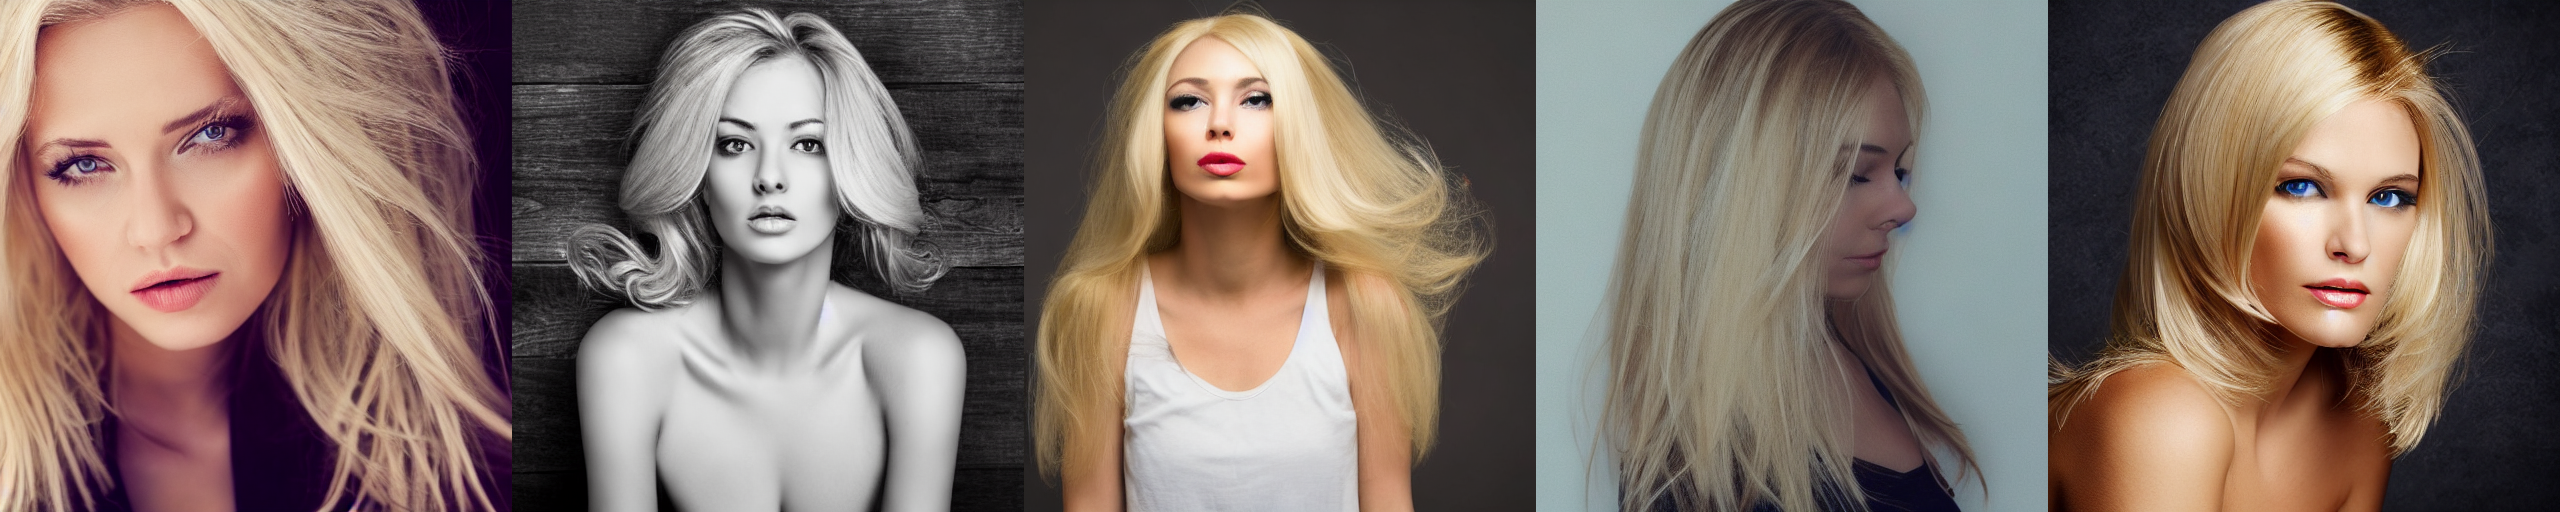

In [38]:

import os
import requests
from io import BytesIO
from PIL import Image
from google.colab import files
from IPython.display import clear_output

# Helper function to display the images
def image_grid(imgPaths, rows, cols):
 assert len(imgPaths) == rows*cols

 imgs = []
 for i, imgPath in enumerate(imgPaths): 
     imgs.append(Image.open(imgPath).convert("RGB"))

 w, h = imgs[0].size
 grid = Image.new('RGB', size=(cols*w, rows*h))
 grid_w, grid_h = grid.size

 for i, img in enumerate(imgs):
  grid.paste(img, box=(i%cols*w, i//cols*h))
 return grid

training_images_directory = "training_images"
training_images = !ls {training_images_directory + "/*"}
# Show the user the images
image_grid(training_images, 1, len(training_images))

In [ ]:
#@title # Training Images
#@markdown ## Upload your training images
#@markdown WARNING: Be sure to upload an even amount of images, otherwise the training inexplicably stops at 1500 steps. <br />
#@markdown - 2-3 full body
#@markdown - 3-5 upper body
#@markdown - 5-12 close-up on face  <br /> <br />
#@markdown The images should be as close as possible to the kind of images you’re trying to make (most of the time, that means no selfies).
import os
import requests
from io import BytesIO
from PIL import Image
from google.colab import files
from IPython.display import clear_output


# Helper function to display the images
def image_grid(imgPaths, rows, cols):
 assert len(imgPaths) == rows*cols

 imgs = []
 for i, imgPath in enumerate(imgPaths): 
     imgs.append(Image.open(imgPath).convert("RGB"))

 w, h = imgs[0].size
 grid = Image.new('RGB', size=(cols*w, rows*h))
 grid_w, grid_h = grid.size

 for i, img in enumerate(imgs):
  grid.paste(img, box=(i%cols*w, i//cols*h))
 return grid


# Create the directory
training_images_directory = "/content/training_images"
!rm -rf {training_images_directory}
!mkdir -p $training_images_directory

# Upload the files
uploaded = files.upload()
for filename in uploaded.keys():
  !mv {filename} {training_images_directory + "/" + filename}
  clear_output()

# Tell the user what is going on
training_images = !ls -d {training_images_directory + "/*"}
if len(training_images) == 0:
    print("❌ no training images found. Please upload images to " + training_images_directory)
else:
  print("✅ " + str(len(training_images)) + " training images found")

# Show the user the images
training_images_to_display = !ls training_images/*

# Show the user the images
image_grid(training_images_to_display, 1, len(training_images_to_display))

In [ ]:
#@title # Training

#@markdown This isn't used for training, just to help you remember what your trained into the model.
project_name = "project_name" #@param {type:"string"}

# MAX STEPS
#@markdown How many steps do you want to train for?
max_training_steps = 2000 #@param {type:"integer"}

#@markdown Match class_word to the category of the regularization images you chose above.
class_word = "person" #@param ["man", "person", "woman"] {allow-input: true}

#@markdown This is the unique token you are incorporating into the stable diffusion model.
token = "firstNameLastName" #@param {type:"string"}
reg_data_root = "/workspace/Dreambooth-Stable-Diffusion/outputs/txt2img-samples/samples/" + dataset

!rm -rf training_samples/.ipynb_checkpoints
!python "main.py" \
 --base configs/stable-diffusion/v1-finetune_unfrozen.yaml \
 -t \
 --actual_resume "model.ckpt" \
 --reg_data_root {reg_data_root} \
 -n {project_name} \
 --gpus 0, \
 --data_root "/workspace/Dreambooth-Stable-Diffusion/training_samples" \
 --max_training_steps {max_training_steps} \
 --class_word {class_word} \
 --token {token} \
 --no-test

In [ ]:
#@title # Prune the Model

directory_paths = !ls -d logs/*
last_checkpoint_file = directory_paths[-1] + "/checkpoints/last.ckpt"
!python "prune_ckpt.py" --ckpt {last_checkpoint_file}
last_checkpoint_file_pruned = directory_paths[-1] + "/checkpoints/last-pruned.ckpt"
training_samples = !ls training_samples
date_string = !date +"%Y-%m-%dT%H-%M-%S"
file_name = date_string[-1] + "_" + project_name + "_" + str(len(training_samples)) + "_training_images_" +  str(max_training_steps) + "_max_training_steps_" + token + "_token_" + class_word + "_class_word.ckpt"
!mkdir -p trained_models
!mv {last_checkpoint_file_pruned} trained_models/{file_name}

print("Download your trained model file from `trained_models/{file_name}` and use in your favorite Stable Diffusion repo!")

In [ ]:
#@title Save model in google drive
from google.colab import drive
drive.mount('/content/drive')

!cp trained_models/{file_name} /content/drive/{file_name}